<a href="https://colab.research.google.com/github/JSunkel/Forecasting-Models/blob/master/SARIMA_monthly_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('drive/My Drive/AirPassengers.csv')

In [0]:
df['Month'] = pd.to_datetime(df['Month'])

In [7]:
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [0]:
y = pd.Series(data = df['#Passengers'].values, index = df['Month'])

In [9]:
y.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
dtype: int64

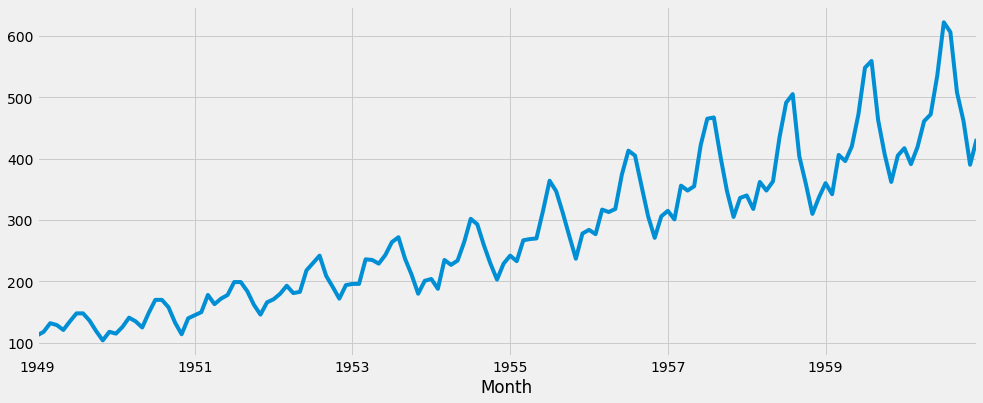

In [11]:
y.plot(figsize = (15, 6))

In [0]:
# Define the p, d, and q parameters to take any value between 0 and 3
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d, and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [16]:
# Ignore warning messages
warnings.filterwarnings("ignore")

best_result = [0, 0, 10000000]
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      model = sm.tsa.statespace.SARIMAX(y,
                                      order = param,
                                      seasonal_order = param_seasonal,
                                      enforce_stationarity = False,
                                      enforce_invertibility = False)
      results = model.fit()
      if results.aic < best_result[2]:
        best_result = [param, param_seasonal, results.aic]
    except:
      continue

print('\nBest Result: ', best_result)


Best Result:  [(2, 1, 2), (0, 2, 2, 12), 715.1571073638156]


In [19]:
# Plot model diagnostics
model = sm.tsa.statespace.SARIMAX(y,
                                  order = (best_result[0][0],
                                           best_result[0][1],
                                           best_result[0][1]),
                                  seasonal_order = (best_result[1][0],
                                                    best_result[1][1],
                                                    best_result[1][2],
                                                    best_result[1][3]),
                                  enforce_stationarity = False,
                                  enforce_invertibility = False)
results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1856      0.195     -6.092      0.000      -1.567      -0.804
ar.L2         -0.4353      0.099     -4.411      0.000      -0.629      -0.242
ma.L1          0.7787      0.204      3.812      0.000       0.378       1.179
ma.S.L12      -1.4145      0.227     -6.239      0.000      -1.859      -0.970
ma.S.L24       0.4839      0.143      3.381      0.001       0.203       0.764
sigma2       118.5126     28.038      4.227      0.000      63.560     173.466


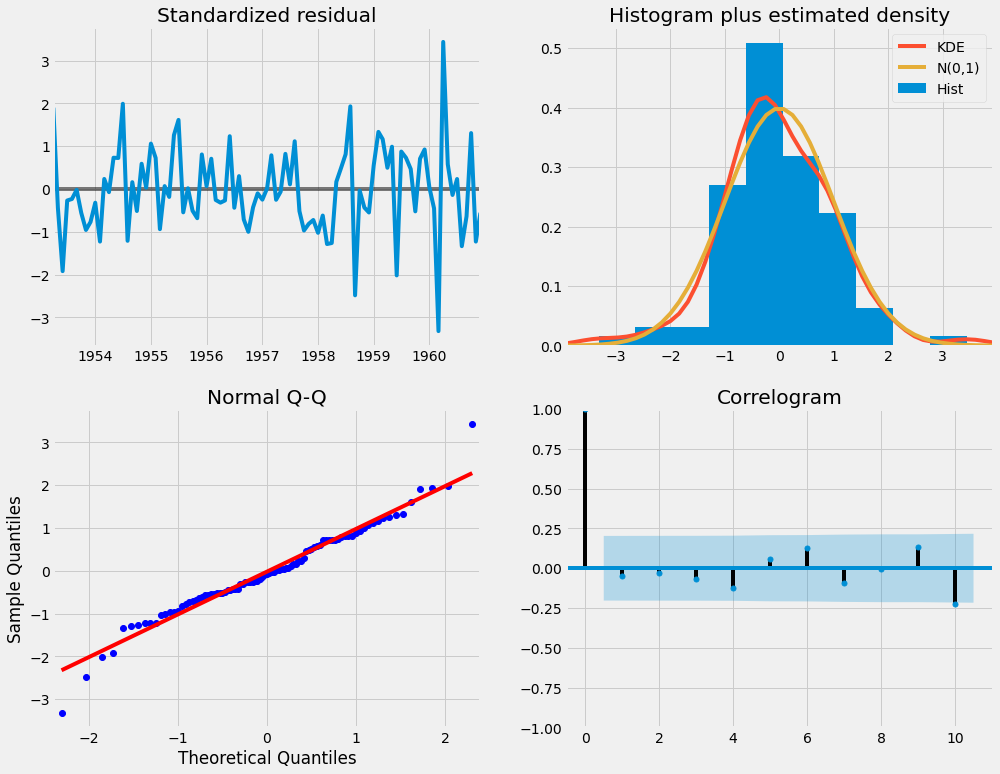

In [20]:
results.plot_diagnostics(figsize = (15, 12))
plt.show()

In [0]:
# Plot one step ahead forecast
pred = results.get_prediction(start = pd.to_datetime('1958-01-01'),
                              dynamic = False)
pred_ci = pred.conf_int()

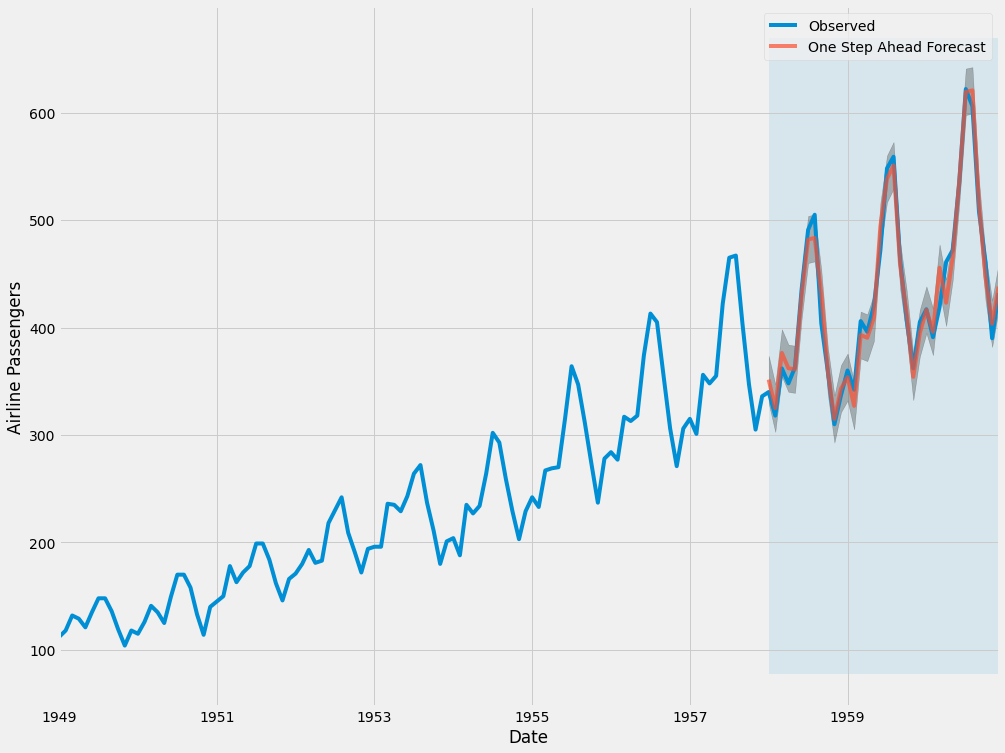

In [22]:
ax = y['1949':].plot(label = 'Observed', figsize = (15, 12))
pred.predicted_mean.plot(ax = ax,
                         label = 'One Step Ahead Forecast',
                         alpha = 0.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color = 'k',
                alpha = 0.25)

ax.fill_betweenx(ax.get_ylim(),
                 pd.to_datetime('1958-01-01'),
                 y.index[-1],
                 alpha = 0.1,
                 zorder = -1)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')
plt.legend()

plt.show()

In [24]:
# Extract the predicted and true values of our time series
y_forecasted = pred.predicted_mean
y_truth = y['1958-01-01':]

# Compute the mean squared error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 194.81


In [0]:
# Plot dynamic forecast
pred_dynamic = results.get_prediction(start = pd.to_datetime('1958-01-01'),
                                      dynamic = True,
                                      full_results = True)
pred_dynamic_ci = pred_dynamic.conf_int()

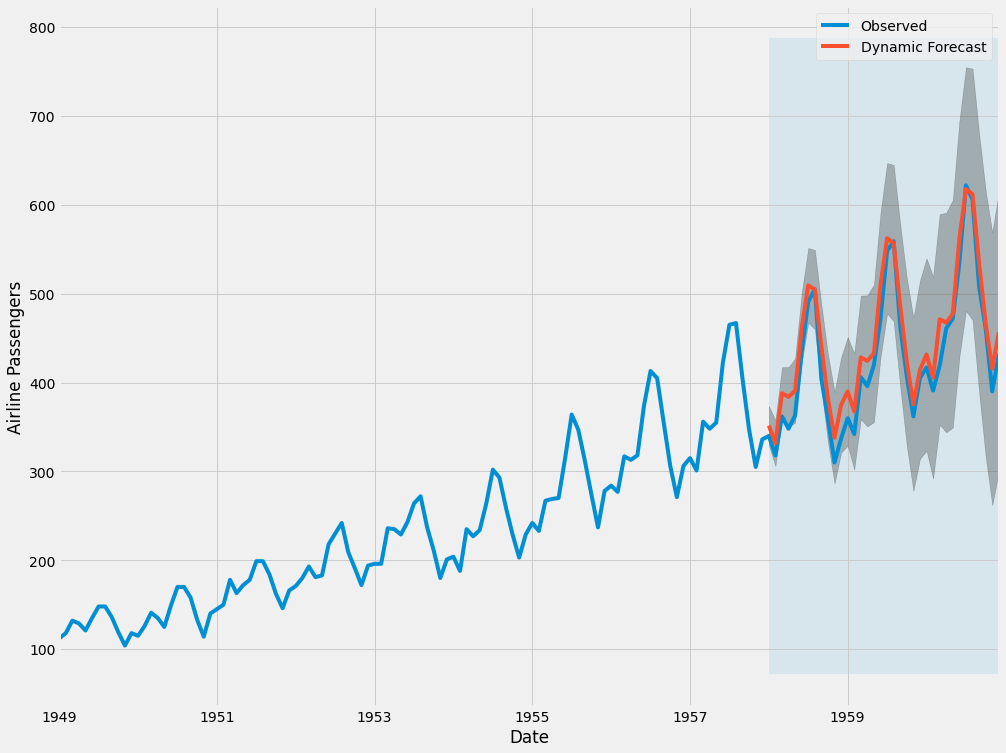

In [27]:
ax = y['1949':].plot(label = 'Observed', figsize = (15, 12))
pred_dynamic.predicted_mean.plot(ax = ax,
                                 label = 'Dynamic Forecast')

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1],
                color = 'k',
                alpha = 0.25)

ax.fill_betweenx(ax.get_ylim(),
                 pd.to_datetime('1958-01-01'),
                 y.index[-1],
                 alpha = 0.1,
                 zorder = -1)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')

plt.legend()

plt.show()

In [28]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1958-01-01':]

# Compute the mean squared error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 551.55


In [0]:
# Get forecast 24 steps ahead in the future
pred_uc = results.get_forecast(steps = 24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

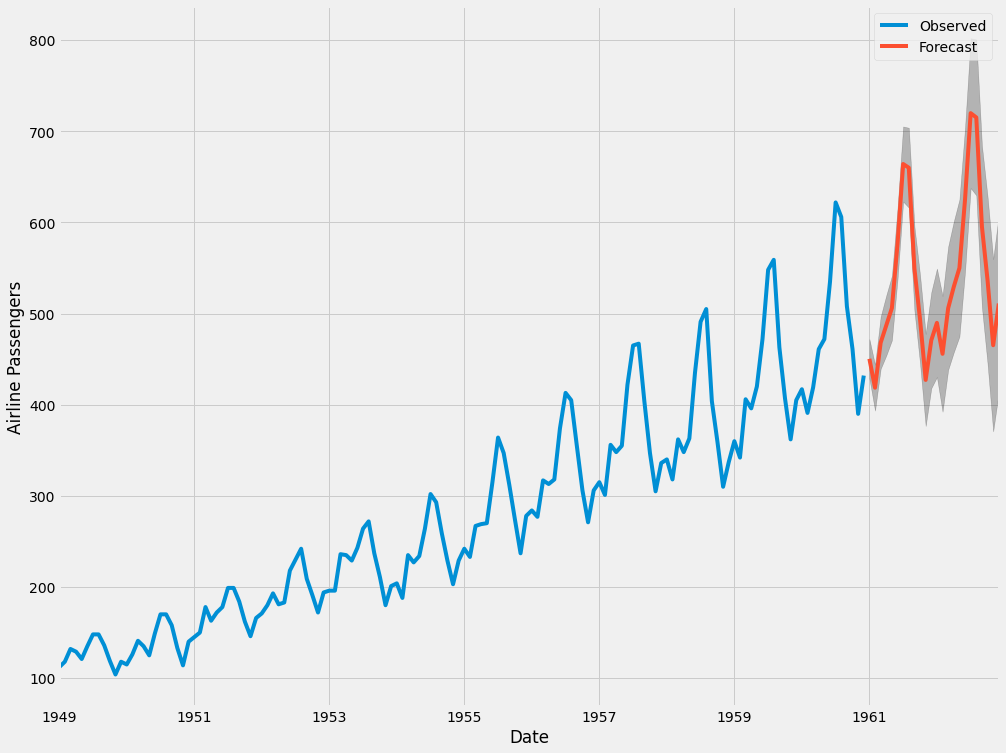

In [30]:
ax = y.plot(label = 'Observed', figsize = (15, 12))
pred_uc.predicted_mean.plot(ax = ax,
                            label = 'Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color = 'k',
                alpha = 0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')

plt.legend()

plt.show()